# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The code below uses a default threshold of 127 to segment the image. Modify it to:

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

28


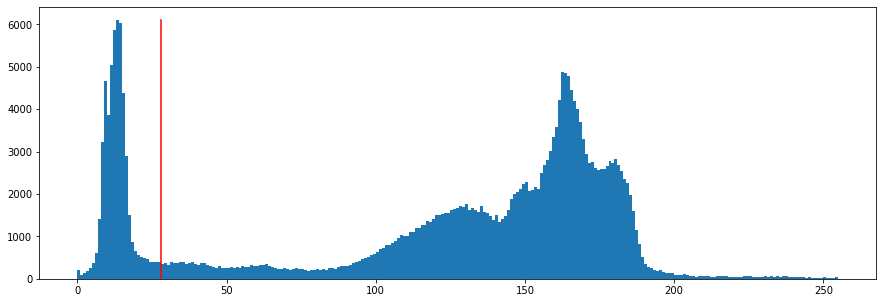

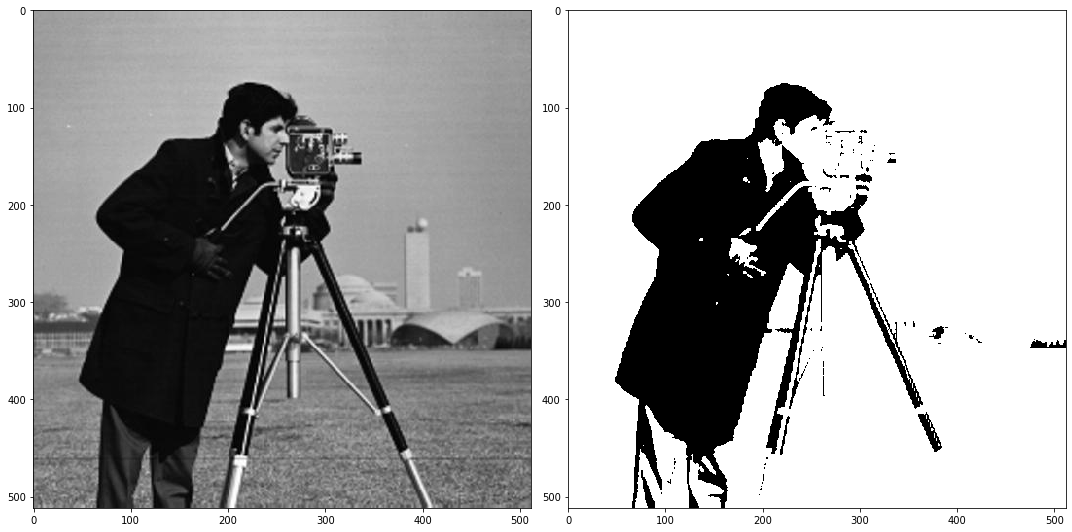

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow

im = imread('camera.jpg')

def optimal_threshold(image):
    dt = 100.0
    T = 127

    def find_median_index(array):
        # median, ignoring NaNs
        amedian = np.median(array)
        # find the index of the closest value to the median in a
        idx = np.nanargmin(np.abs(array-amedian))
        return idx

    T_values = []
    while dt > 1.0 and T not in T_values:
        T_values.append(T)
        # compute the histogram
        h = np.histogram(im.flatten(), bins=range(256))
        # divides the histogram in two parts
        h_values = h[0]
        h_left = h_values[:T]
        h_right = h_values[T:]
        centroid_left = find_median_index(h_left)
        centroid_right = find_median_index(h_right)
        T_ = (centroid_left + centroid_right) / 2
        dt = np.abs(T_ - T)
        T = int(T_)

    return T

def otsu_threshold(image):
    
    def class_probability(array, threshold, start = 0):
        # array is the probability distribution 
        sum_ = 0.0
        for idx in range(start, threshold):
            sum_ += array[idx]
        return sum_
            
    def class_mean(array, proba, threshold, start = 0):
        # array is the probability distribution
        # proba is the probability value of the class
        sum_ = 0.0
        for idx in range(start, threshold):
            sum_ += idx * (array[idx] / proba)
        return sum_
            
    def class_variance(array, class_mean, class_prob, threshold, start = 0):
        sum_ = 0.0
        for idx in range(start, threshold):
            sum_ += ((idx - class_mean) ** 2) * (array[idx] / class_prob)
        return sum_
    
    T = 127
    prob = np.histogram(image.flatten(), bins=range(256))[0] / (image.shape[0] * image.shape[1])
    results = np.zeros(255, dtype=np.float32)
    # for all the possible threshold values on a 8-bit image 
    for T in range(1, 255):
        # Computes 
        c_prob_1 = class_probability(prob, T)
        c_prob_2 = 1 - c_prob_1
        c_mean_total = class_mean(prob, 1.0, 255)
        c_mean_1 = class_mean(prob, c_prob_1, T)
        c_mean_2 = (c_mean_total - c_mean_1) / (1 - c_prob_1)
        c_var_1 = class_variance(prob, c_mean_1, c_prob_1, T)
        c_var_2 = class_variance(prob, c_mean_2, c_prob_2, 255, start=T)

        var_interclass = (c_prob_1 * c_prob_2) * ((c_mean_2 - c_mean_1) ** 2)
        total_var = 0.0
        for idx in range(0, T):
            total_var += ((idx - c_mean_total) ** 2) * prob[idx]
        results[T] = var_interclass / total_var
        
    max_value = 0.0
    max_index = 0
    for idx in range(1, 255):
        if results[idx] > max_value:
            max_value = results[idx]
            max_index = idx
            
    return max_index

# T = optimal_threshold(im)
T = otsu_threshold(im)
print(T)
    
# Plot histogram and arbitrary threshold:
plt.figure(figsize=(15,5))
h = plt.hist(im.flatten(), bins=range(256))
plt.plot([T,T],[0,h[0].max()], 'r-')

# Show original image & segmented binary image
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
imshow(im)
plt.subplot(1,2,2)
imshow(im>T)
plt.show()

## 2. Texture segmentation

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [

ValueError: could not broadcast input array from shape (256,256,20,20) into shape (120,160)

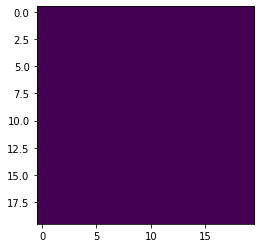

In [54]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops

def texture_descriptor(N):
    angles = np.linspace(-np.pi/4, np.pi/4, 20)
    distances = np.linspace(40, 70, 20)
    comat = greycomatrix(N, distances, angles)
    print(comat)
    plt.imshow(comat[0, 0, :, :])
    return comat

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

im_descr = sliding_window(im,(120,160))
T = threshold_otsu(im_descr)
mask = im_descr>T

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
imshow(im)
plt.title('Original')
plt.subplot(1,3,2)
imshow(im_descr)
plt.title('Descriptor image')
plt.subplot(1,3,3)
imshow(im*mask)
plt.title('Result')
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. The example below uses the watershed transform on the cameraman image, with hand-picked markers:

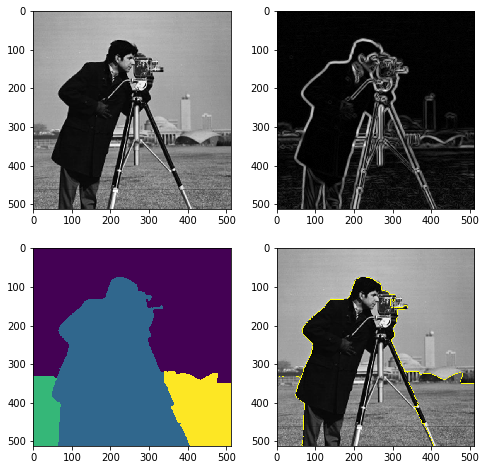

In [3]:
from skimage.morphology import watershed,disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries
from skimage.io import imread


im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers = np.zeros_like(im)
markers[10,256] = 1 # in the sky
markers[200,150] = 2 # in the cameraman
markers[400,20] = 3 # in the grass (left of cameraman)
markers[400,450] = 4 # in the grass (right of cameraman)

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

Adapt this method to work on the road image.

Can you find a way to automatically determine the markers?

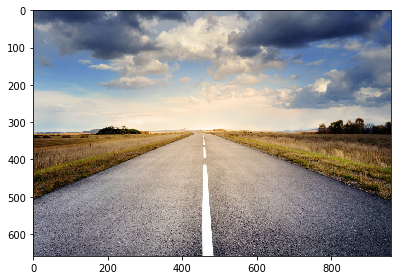

In [4]:
im = imread('road.jpg')

imshow(im)

Another use of the watershed transform is to separate overlapping object, as in the image below.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

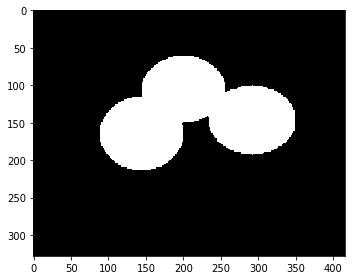

In [5]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray

im = rgb2gray(imread('separ.png'))==0
imshow(im)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Starting from the example below:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

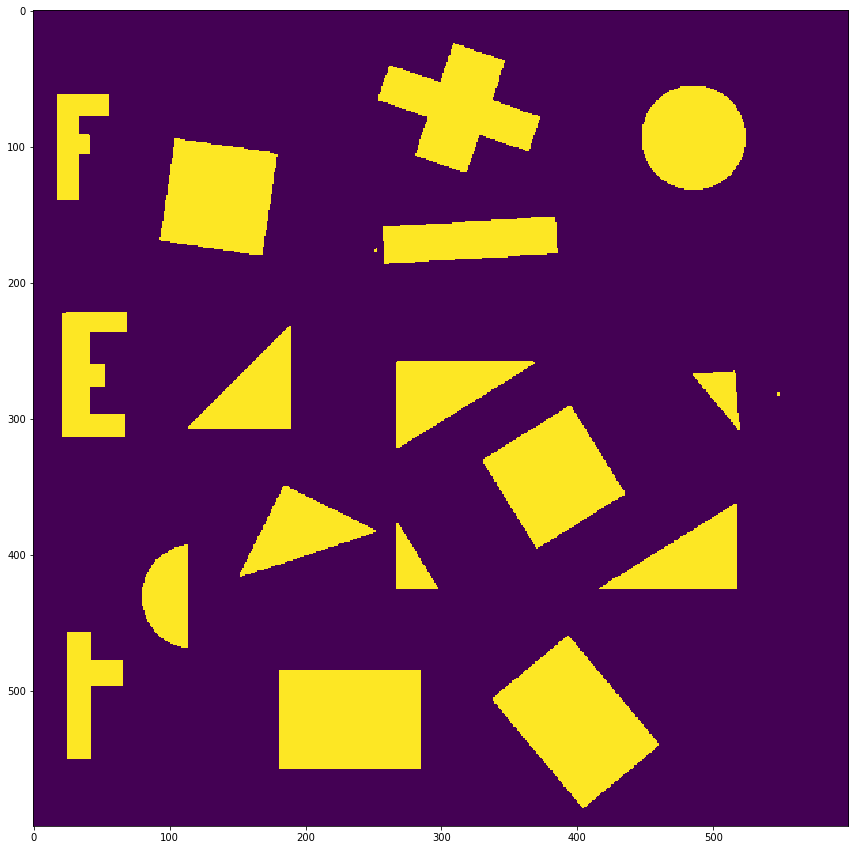

In [6]:
from skimage.measure import label, regionprops,find_contours

im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later

plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

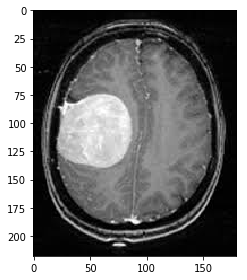

In [7]:
from skimage.io import imread,imshow
%matplotlib inline

im = imread('mri_brain.jpg')
imshow(im)